<a href="https://colab.research.google.com/github/macgyver121/DADS7202_hw2/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [324]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5ace513f-481d-ec23-68ed-65665f384339)


In [325]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.8.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


## mount google drive + import library

In [326]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [327]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [328]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow_hub as hub

## Import + Prepare Data

In [329]:
# Getting names of the classes we have
data_directory = pathlib.Path('/content/drive/MyDrive/hw2_DADS7202_photo')
class_names = [item.name for item in data_directory.glob('*')][0:]
class_names.sort()
print(class_names)

['battery', 'drug', 'fluorescent', 'mask', 'spray']


In [330]:
spray_dir = '/content/drive/MyDrive/hw2_DADS7202_photo/spray' 
drug_dir = '/content/drive/MyDrive/hw2_DADS7202_photo/drug'
mask_dir = '/content/drive/MyDrive/hw2_DADS7202_photo/mask'
battery_dir = '/content/drive/MyDrive/hw2_DADS7202_photo/battery'
fluorescent_dir = '/content/drive/MyDrive/hw2_DADS7202_photo/fluorescent'
data_dir = '/content/drive/MyDrive/hw2_DADS7202_photo'

In [331]:
spray_images = len(os.listdir(spray_dir))
drug_images = len(os.listdir(drug_dir))
mask_images = len(os.listdir(mask_dir))
battery_images = len(os.listdir(battery_dir))
fluorescent_images = len(os.listdir(fluorescent_dir))

print(f'Number of ampule images: {spray_images}')
print(f'Number of drug images: {drug_images}')
print(f'Number of ampule images: {mask_images}')
print(f'Number of ampule images: {battery_images}')
print(f'Number of ampule images: {fluorescent_images}')

Number of ampule images: 40
Number of drug images: 50
Number of ampule images: 40
Number of ampule images: 50
Number of ampule images: 40


In [332]:
np.random.seed(1234)
tf.random.set_seed(5678)

# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.3)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 300,
                                          subset = 'training',
                                          class_mode = 'binary')
test_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 300,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 154 images belonging to 5 classes.
Found 66 images belonging to 5 classes.


In [333]:
x_train, y_train = train_data.next()
len(x_train), len(y_train), x_train[0].shape

(154, 154, (224, 224, 3))

In [334]:
x_test, y_test = test_data.next()
len(x_test), len(y_test), x_test[0].shape

(66, 66, (224, 224, 3))

In [335]:
print(x_train[0:1])

[[[[0.2392157  0.21568629 0.16862746]
   [0.2509804  0.227451   0.17254902]
   [0.25882354 0.23529413 0.17254902]
   ...
   [0.8941177  0.9058824  0.92549026]
   [0.8941177  0.9058824  0.92549026]
   [0.92549026 0.93725497 0.9568628 ]]

  [[0.23137257 0.21568629 0.17254902]
   [0.24313727 0.23137257 0.17254902]
   [0.26666668 0.24313727 0.18039216]
   ...
   [0.8862746  0.8980393  0.9176471 ]
   [0.882353   0.8941177  0.91372555]
   [0.89019614 0.90196085 0.9215687 ]]

  [[0.23529413 0.21960786 0.1764706 ]
   [0.25490198 0.24313727 0.18431373]
   [0.2784314  0.26666668 0.20784315]
   ...
   [0.909804   0.9215687  0.94117653]
   [0.8745099  0.8862746  0.9058824 ]
   [0.8862746  0.8980393  0.9176471 ]]

  ...

  [[0.27058825 0.27058825 0.2392157 ]
   [0.29411766 0.2901961  0.27058825]
   [0.2901961  0.28627452 0.26666668]
   ...
   [0.54509807 0.5176471  0.4784314 ]
   [0.54509807 0.5176471  0.4784314 ]
   [0.5529412  0.5254902  0.48627454]]

  [[0.27450982 0.2784314  0.25490198]
   [0.2

In [336]:
print(x_train.shape)
print(y_train.shape)

(154, 224, 224, 3)
(154,)


In [337]:
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(154, 224, 224, 3) , min=0.0 , max=1.0


In [338]:
for i in range(20) :
    print(y_train[i])

2.0
1.0
3.0
0.0
0.0
3.0
3.0
1.0
4.0
3.0
1.0
0.0
1.0
1.0
0.0
3.0
1.0
3.0
2.0
1.0


In [339]:
print(type(x_train))
print(x_train.dtype)

<class 'numpy.ndarray'>
float32


In [340]:
print(type(y_train))
print(y_train.dtype)

<class 'numpy.ndarray'>
float32


In [341]:
'''def plot_random_images():
    i = 1

    plt.figure(figsize = (10, 5))
    
    for x, y in zip(x_train, y_train):
        plt.subplot(2, 5, i)
        plt.imshow(x)
        plt.title(class_names[y])
        plt.axis('off')
        i += 1
        if i == 10:
            break

    plt.tight_layout()       
    plt.show()'''

"def plot_random_images():\n    i = 1\n\n    plt.figure(figsize = (10, 5))\n    \n    for x, y in zip(x_train, y_train):\n        plt.subplot(2, 5, i)\n        plt.imshow(x)\n        plt.title(class_names[y])\n        plt.axis('off')\n        i += 1\n        if i == 10:\n            break\n\n    plt.tight_layout()       \n    plt.show()"

In [342]:
'''plot_random_images()'''

'plot_random_images()'

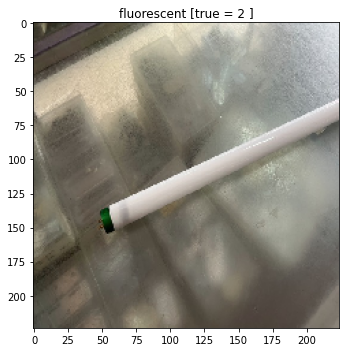

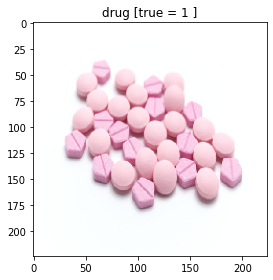

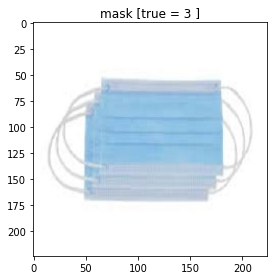

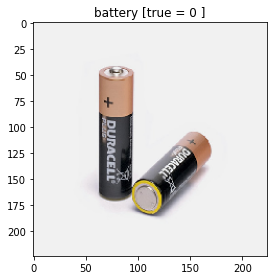

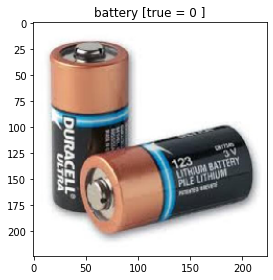

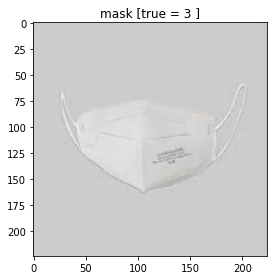

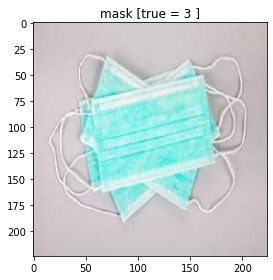

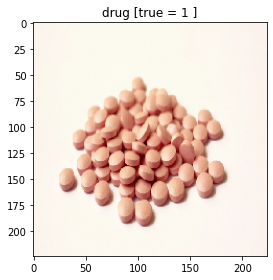

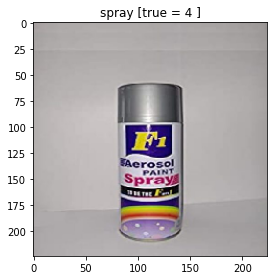

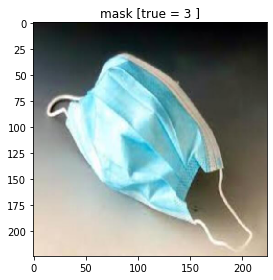

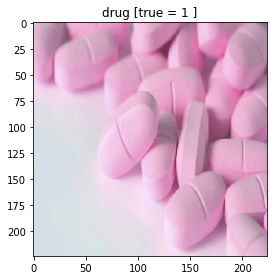

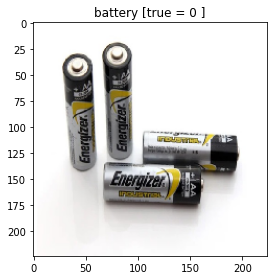

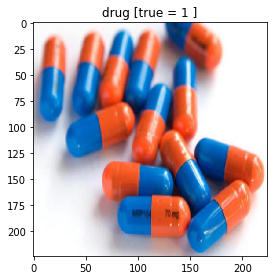

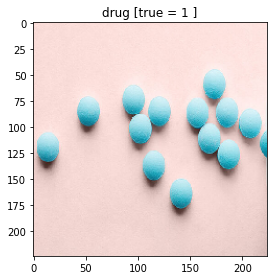

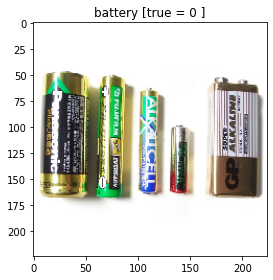

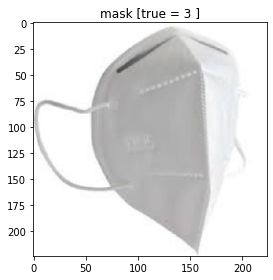

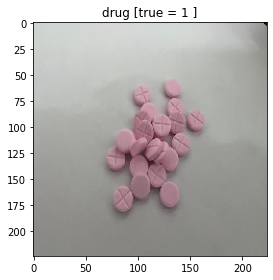

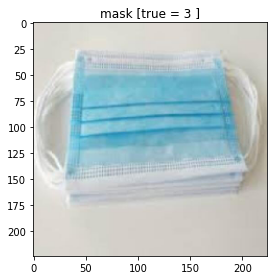

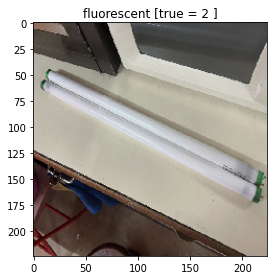

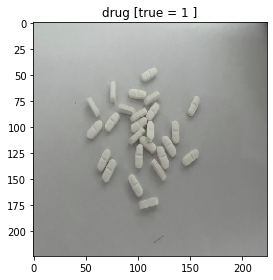

In [343]:
# Visualize the first five images in x_train
plt.figure(figsize=(10,5))
for i in range(0,20):
    plt.title( f"{class_names[ int(y_train[i]) ]} [true = {int(y_train[i])} ]") 
    plt.imshow( x_train[i] )  
    plt.tight_layout()       
    plt.show()

In [344]:
# x_train_int = x_train.astype(np.uint8)

In [345]:
# print( f"x_train_int: type={type(x_train_int)} , dtype={x_train_int.dtype} , shape={x_train_int.shape} , min={x_train_int.min(axis=None)} , max={x_train_int.max(axis=None)}" )

## Prepare pretrained Model

In [346]:
# Load the ImageNet VGG-16 model, including both the feature extractor part and the classifier part
# By default, VGG-16 is designed for an input image of dimension 224x224x3
vgg = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=True)

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [347]:
from keras.models import Model

vgg_extractor= Model(inputs=vgg.input, outputs=vgg.layers[-2].output)
vgg_extractor.summary()

for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [348]:
vgg_extractor.trainable = False

for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_7 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False
Layer 19: name = flatten , trainable = False
Layer 20: name = fc1 , tr

In [349]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model 

new_outputs = tf.keras.layers.Dense(5, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [350]:
print( f"type(img) = {type(train_data)}" )

type(img) = <class 'keras.preprocessing.image.DirectoryIterator'>


In [351]:
print(y_train[0:10])

[2. 1. 3. 0. 0. 3. 3. 1. 4. 3.]


In [352]:
print(x_train.dtype)

float32


In [353]:
# Preprocess the image following requirements of VGG-16
x_train_vgg = tf.keras.applications.vgg16.preprocess_input(x_train)
print( f"type(x) = {type(x_train_vgg)} , x.dtype = {x_train_vgg.dtype} , x.shape = {x_train_vgg.shape} , min(x) = {np.min(x_train_vgg):.4f} , max(x) = {np.max(x_train):.4f}" )

type(x) = <class 'numpy.ndarray'> , x.dtype = float32 , x.shape = (154, 224, 224, 3) , min(x) = -123.6800 , max(x) = -102.9390


In [354]:
# Preprocess CIFAR-10 dataset to match VGG-16's requirements
#x_train_vgg = tf.keras.applications.vgg16.preprocess_input(train_data)
#x_test_vgg = tf.keras.applications.vgg16.preprocess_input(val_data)

#print( x_train_vgg.dtype, x_train_vgg.shape, np.min(x_train_vgg), np.max(x_train_vgg) )
#print( x_test_vgg.dtype, x_test_vgg.shape, np.min(x_test_vgg), np.max(x_test_vgg) )

## Train the model with transfer learning

In [355]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

In [356]:
history = model.fit( x_train_vgg , y_train, batch_size=32, epochs=20, verbose=1, validation_split=0.3 )

Epoch 1/20
4/4 [==============================] - 2s 293ms/step - loss: 1.9000 - acc: 0.1589 - val_loss: 1.8815 - val_acc: 0.1915
Epoch 2/20
4/4 [==============================] - 1s 203ms/step - loss: 1.8368 - acc: 0.1682 - val_loss: 1.6316 - val_acc: 0.2340
Epoch 3/20
4/4 [==============================] - 1s 204ms/step - loss: 1.7263 - acc: 0.2056 - val_loss: 1.8048 - val_acc: 0.1702
Epoch 4/20
4/4 [==============================] - 1s 205ms/step - loss: 1.7035 - acc: 0.2523 - val_loss: 1.8433 - val_acc: 0.1702
Epoch 5/20
4/4 [==============================] - 1s 204ms/step - loss: 1.7765 - acc: 0.1215 - val_loss: 1.6729 - val_acc: 0.2553
Epoch 6/20
4/4 [==============================] - 1s 204ms/step - loss: 1.6446 - acc: 0.2150 - val_loss: 1.7171 - val_acc: 0.1489
Epoch 7/20
4/4 [==============================] - 1s 206ms/step - loss: 1.7143 - acc: 0.2150 - val_loss: 1.7306 - val_acc: 0.1702
Epoch 8/20
4/4 [==============================] - 1s 204ms/step - loss: 1.6344 - acc: 0.25

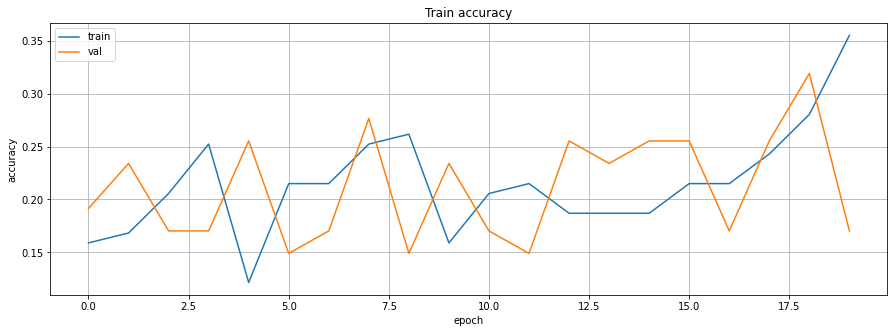

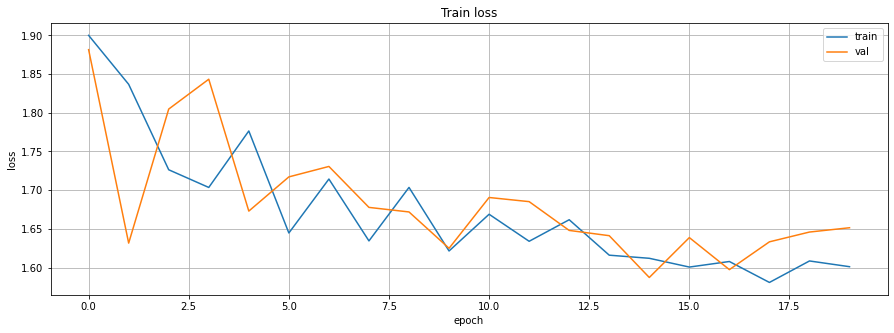

In [357]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

## Evaluate the model on test set

In [358]:
x_test_vgg = tf.keras.applications.vgg16.preprocess_input(x_test)

In [359]:
# Evaluate the trained model on the test set
results = model.evaluate(x_test_vgg, y_test, batch_size=128)
print( f"{model.metrics_names}: {results}" )

1/1 [==============================] - 0s 415ms/step - loss: 1.6230 - acc: 0.2273
['loss', 'acc']: [1.6229946613311768, 0.22727273404598236]


## Inference

In [360]:
y_pred = model.predict(x_test_vgg)
print((y_pred))
print(y_pred.shape)

[[0.17395167 0.33499095 0.21917258 0.14127272 0.13061205]
 [0.18349831 0.32997873 0.21687241 0.1297704  0.13988017]
 [0.17245609 0.33575264 0.22000061 0.14267786 0.12911274]
 [0.17164308 0.3362168  0.22019503 0.14232317 0.12962194]
 [0.17922503 0.3339932  0.21782818 0.13211896 0.13683459]
 [0.17150564 0.33523226 0.2207912  0.14288405 0.12958688]
 [0.17159401 0.33626783 0.22028486 0.1420046  0.12984872]
 [0.17574798 0.3344053  0.21908334 0.13845828 0.13230515]
 [0.17804438 0.3341204  0.21773082 0.13831984 0.13178465]
 [0.17204832 0.33550888 0.22023982 0.14253464 0.1296684 ]
 [0.17354773 0.33545992 0.21922171 0.14219347 0.1295772 ]
 [0.17533062 0.33490232 0.21823537 0.1414076  0.13012406]
 [0.17674041 0.33489725 0.21750815 0.14054368 0.13031043]
 [0.17219651 0.3355252  0.2201076  0.14215612 0.13001448]
 [0.17150564 0.33523226 0.2207912  0.14288405 0.12958688]
 [0.17783916 0.33262858 0.21776132 0.13847412 0.13329679]
 [0.17214678 0.33592573 0.22000048 0.14201093 0.12991606]
 [0.17984983 0

In [361]:
lst = []
for i in y_pred :
    lst.append(np.argmax(i))

type(np.array(lst))

numpy.ndarray

In [362]:
y_test[0:10]

array([2., 0., 3., 1., 1., 2., 1., 1., 0., 2.], dtype=float32)

In [363]:
lst[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [364]:
print(x_test[0:1])

[[[[-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   ...
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]]

  [[-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   ...
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]]

  [[-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   ...
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]]

  ...

  [[-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   ...
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]]

  [[-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   ...
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 -102.939]
   [-122.68  -115.779 

In [365]:
x_test, y_test = test_data.next()

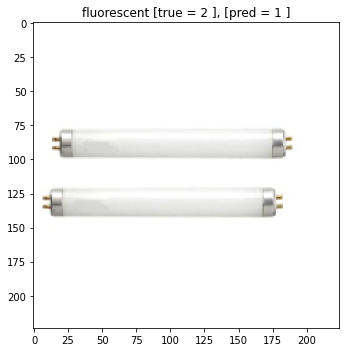

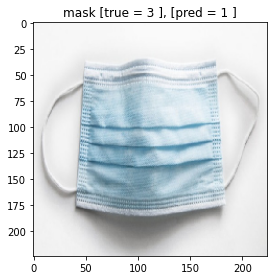

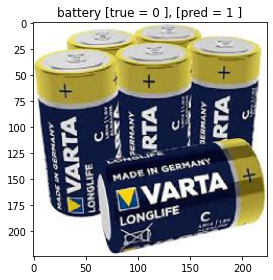

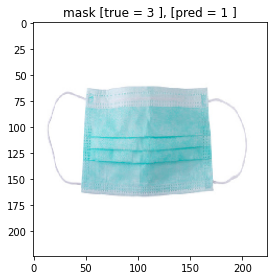

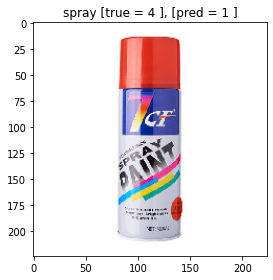

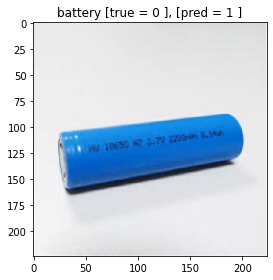

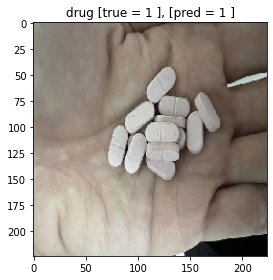

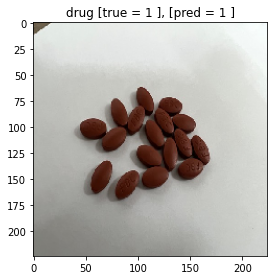

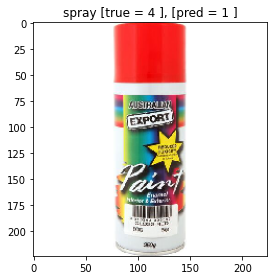

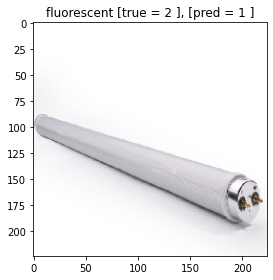

In [367]:
# Visualize the first five images in test
plt.figure(figsize=(10,5))
for i in range(0,10):
    plt.title( f"{class_names[ int(y_test[i]) ]} [true = {int(y_test[i])} ], [pred = {lst[i]} ]") 
    plt.imshow( x_test[i] )  
    plt.tight_layout()       
    plt.show()